In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate, integrate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
import winsound
import pickle

eSOH_DIR = "../data/esoh_R/"
oCV_DIR = "../data/ocv/"
cyc_DIR = "../data/cycling/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
%matplotlib widget

In [2]:
parameter_values = get_parameter_values()
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
        "stress-induced diffusion": "false",
    }
)
# spm.print_parameter_info()
param=spm.param

In [3]:
cell = 19
sno = 7
sim_des = f'cond{sno}'
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
print(Temp)

25


In [4]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
drive_cycle = pd.read_csv(cyc_DIR+'peyman_drive_cycle_current'+'.csv', comment="#", header=None).to_numpy()
experiment = pybamm.Experiment(
    [
        ("Run DriveCycle (A)",
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *dfe.N.iloc[-1],
    # ] *1,
    drive_cycles={"DriveCycle": drive_cycle},
    termination="50% capacity",
#     cccv_handling="ode",
)

In [5]:
df_dc = pd.read_csv(cyc_DIR+'peyman_drive_cycle_current'+'.csv')

In [6]:
t = df_dc["# t [s]"].to_numpy()
I = df_dc[" Current [A]"].to_numpy()

In [7]:
I*=I>0

In [8]:
I_int = integrate.cumtrapz(I,t,initial=0)
I_int = I_int[-1]

In [9]:
I_int/t[-1]/5

0.26212839093201074

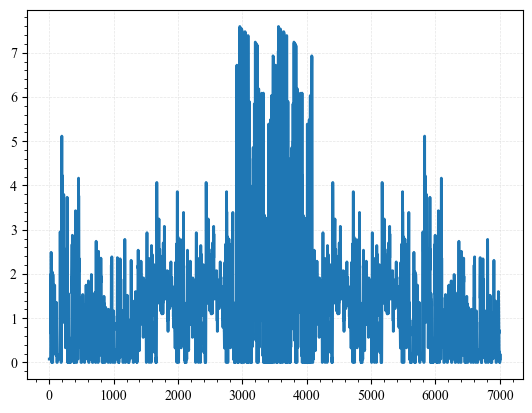

In [10]:
fig,ax = plt.subplots(1,1)
ax.plot(t,I)

In [11]:
par_val = {}
# Previous i.e. tuning mech sim sep and then Li plating
par_val[0]=[1.2715e-07,1.2727e-06,1.1992,1.353e-9]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,x100,y0
par_val[1]=[1.4819e-07,1.5114e-06,1.2484,1.4732e-09]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[2]=[1.4493e-07,1.3608e-06,1.199,1.2138e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,x100,y0
par_val[3]=[1.043e-07,1.036e-06,1.208,1.6045e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[4]=[8.755e-08,8.572e-07,1.135,1.5788e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%) another initial condition
par_val[5]=[8.7698e-08,8.5848e-07,1.1354,1.5778e-09]
# New Mech Damage Model
par_val[6]=[2.056E-07,2.4664E-06,1.2468,1.0482e-09]
# New Mech Damage Model with Lithium plating resistane
par_val[7]=[2.190e-07,2.308e-06,1.214,2.537e-09]

In [12]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": par_val[sno][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[sno][1],
        "Positive electrode LAM constant exponential term": par_val[sno][2],
        "Negative electrode LAM constant exponential term": par_val[sno][2],
        "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
        "Lithium plating kinetic rate constant [m.s-1]": par_val[sno][3],
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 30000.0,
        "Positive electrode LAM constant proportional term [s-1]": 1.85e-07,
        "Negative electrode LAM constant proportional term [s-1]":2.75e-6,
        "Positive electrode LAM constant exponential term": 2*0.682,
        "Negative electrode LAM constant exponential term": 2*0.682,
        "Lithium plating kinetic rate constant [m.s-1]": 2.5e-9,
        "Positive electrode LAM additional term [s-1]": 0*1e-11,
        "Negative electrode LAM additional term [s-1]": 0.3*1e-8,
    },
    check_already_exists=False,
)


In [13]:
def plotc(all_sumvars_dict,esoh_data):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.set_title(split_long_string(name))
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Sim"] + ["Data"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

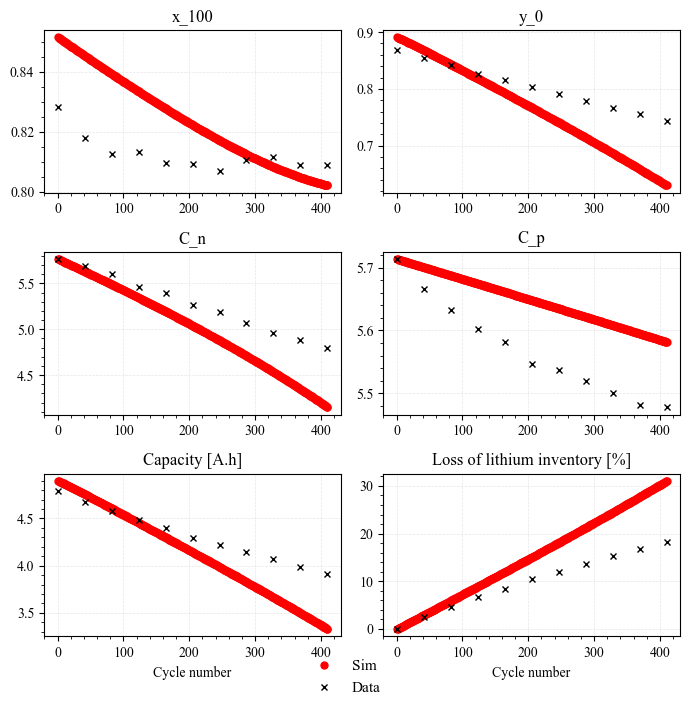

In [14]:
all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1,drive_cycle=drive_cycle)
fig = plotc(all_sumvars_dict,dfe);
plt.show()

In [ ]:
cvcxv

In [15]:
with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'wb') as handle:
        pickle.dump(all_sumvars_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
sdfsd

NameError: name 'sdfsd' is not defined

In [ ]:
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
# sol_long = sim_long.solve(initial_soc=1,save_at_cycles=20)
sol_long = sim_long.solve(initial_soc=1)
long_sol_output =sol_long.summary_variables
# sol_long.save(res_DIR+'normal_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle')

In [ ]:
# sol_long = pybamm.load(res_DIR+'normal_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle')
# long_sol_output =sol_long.summary_variables

In [ ]:
fig = plotc(long_sol_output,dfe);
fig.savefig(fig_DIR +'fast_sim_'+sim_des+"_cell_"+cell_no+'.png')

In [ ]:
dfsdfsd

In [ ]:
dfdsfs

In [ ]:
eSOH = all_sumvars_dict
Cn = eSOH["C_n"][Ns]
Cp = eSOH["C_p"][Ns]
C = eSOH["C"][Ns]
x100 = eSOH["x_100"][Ns]
x0 = eSOH["x_0"][Ns]
y100 = eSOH["y_100"][Ns]
y0 = eSOH["y_0"][Ns]
LLI = eSOH["Loss of lithium inventory [%]"][Ns]

df = pd.DataFrame({'N':N,'Cn':Cn,'Cp':Cp,'C':C,'x0':x0,'x100':x100,'y0':y0,'y100':y100,'LLI':LLI,
                    })
df.to_csv(res_DIR + "aging_sim_eSOH_cell_"+cell_no+".csv", index=False)

In [ ]:
# fig = plotc2(all_sumvars_dict,long_sol_output,dfe,leg1="Accelerated",leg2="Normal");

In [ ]:
dcffsdf

In [ ]:
spm.variables.search("sei")

In [ ]:
t = sol_long["Time [s]"].entries
I = sol_long["Current [A]"].entries
Q = -sol_long['Discharge capacity [A.h]'].entries
Vt = sol_long["Terminal voltage [V]"].entries
I_Li = sol_long["X-averaged lithium plating interfacial current density [A.m-2]"].entries
Q_Li = sol_long["Loss of capacity to lithium plating [A.h]"].entries
i0_int = sol_long["X-averaged negative electrode exchange current density [A.m-2]"].entries
I_de = sol_long["X-averaged negative electrode interfacial current density [A.m-2]"].entries
I_st = sol_long["X-averaged lithium plating interfacial current density"].entries
I_to = sol_long["X-averaged negative electrode total interfacial current density [A.m-2]"].entries
I_sei = sol_long["X-averaged SEI interfacial current density [A.m-2]"].entries

In [ ]:
fig,ax = plt.subplots(2,1)
ax1 = ax.flat[0]
ax1.plot(t,I_de)
ax2 = ax.flat[1]
ax2.plot(t,I_Li)
ax2.plot(t,I_sei)

In [ ]:
fig,ax = plt.subplots(1,1)
ax1 = ax
ax1.plot(t,I_de)
ax1.plot(t,I_Li)


In [ ]:
fig,ax = plt.subplots(2,1)
ax1 = ax.flat[0]
ax1.plot(t,I)
ax2 = ax.flat[1]
ax2.plot(t,Vt)

In [ ]:
fig,ax = plt.subplots(1,1)
ax1 = ax
ax1.plot(t,I_Li)

In [ ]:
def load_cycling_data(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no):
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    cycles = np.array(dfe_0['N'].astype('int'))+1
    cycles = cycles[1:-1]
    print(cell_no)
    cyc_data_raw1 = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
    N1 = cycles[cyc_no]
    cyc_data_raw = cyc_data_raw1[ cyc_data_raw1['Cycle number'] == N1 ]
    cyc_data = cyc_data_raw.reset_index(drop=True)
    t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
    t_c1 = t_c1.values
    I_c1 = cyc_data['Current [mA]']/1000
    I_c1 = I_c1.values
    V_c1 = cyc_data['Voltage [V]']
    V_c1 = V_c1.values
    idx_I = np.where(np.sign(I_c1[:-1]) != np.sign(I_c1[1:]))[0] 
    idx_I = idx_I[idx_I>50]
    # t = t_c1[:idx_I[0]]
    # V = V_c1[:idx_I[0]]
    # I = I_c1[:idx_I[0]]
    t = t_c1
    V = V_c1
    I = I_c1
    Q = integrate.cumtrapz(I,t, initial=0)/3600 #Ah
    
    return t,V,I,Q

In [ ]:
cyc_no = 0
t_d,V_d,I_d,Q_d = load_cycling_data(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)

In [ ]:
fig,ax = plt.subplots(2,1)
ax1 = ax.flat[0]
ax1.plot(t_d,-I_d,'k')
ax1.plot(t-1260,I)
ax2 = ax.flat[1]
ax2.plot(t_d,V_d,'k')
ax2.plot(t-1260,Vt)

# Resistance Plots

In [ ]:
dfe

In [ ]:
t_in0 = 10
t_in1 = 10
t_inf = t_in0+t_in1
# t_in = np.arange(0,t_inf,0.1)
t_in = np.arange(0,t_inf,1)
# t_sim = np.arange(0,t_inf,0.01)
I_in = []
for tt in t_in:
    if tt<t_in0:
        I_in = np.append(I_in,0)
    elif tt>=t_in0 and tt<t_in0+t_in1:
        I_in = np.append(I_in,5)
# I_in = np.array([0,0,5,5,0,0,-5,-5,0,0])
timescale = parameter_values.evaluate(spm.timescale)

def get_pulse_res(parameter_values,SOC):
    sim_pulse = pybamm.Simulation(spm, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver(mode="safe", rtol=1e-6, atol=1e-6,dt_max=0.1))
    sol_pulse = sim_pulse.solve(t_eval=t_in,initial_soc = SOC)
    I   =  sol_pulse["Current [A]"].entries
    Vt  =  sol_pulse["Terminal voltage [V]"].entries
    idx = np.where(np.diff(np.sign(-I)))[0]
    Rs = abs((Vt[idx+1]-Vt[idx])/(I[idx+1]-I[idx]))[0]
    return Rs

def get_Rs(cyc_no,eSOH,parameter_values):
  Cn = eSOH["C_n"][Ns[cyc_no]]
      # print(Cn)
  Cp = eSOH["C_p"][Ns[cyc_no]]
  c_n_max = parameter_values.evaluate(param.n.prim.c_max)
  c_p_max = parameter_values.evaluate(param.p.prim.c_max)
  n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
  eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
  eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))
  del_sei = eSOH['X-averaged SEI thickness [m]'][Ns[cyc_no]]
  parameter_values.update(
          {
              "Negative electrode active material volume fraction": eps_n_data,
              "Positive electrode active material volume fraction": eps_p_data,
              "Initial inner SEI thickness [m]": 0e-09,
              "Initial outer SEI thickness [m]": del_sei,
              
          }
        )
  timescale = parameter_values.evaluate(spm.timescale)
  current_interpolant = pybamm.Interpolant(
    t_in, -I_in, timescale * pybamm.t
  )
  parameter_values["Current function [A]"] = current_interpolant
  SOC_vals = np.linspace(1,0,11)
  Rs_ch_s = []
  for SOC in SOC_vals[1:10]:
      Rs_t = get_pulse_res(parameter_values,SOC)
      Rs_ch_s.append(Rs_t)
  Rs_ch = np.average(Rs_ch_s)
  
  current_interpolant = pybamm.Interpolant(
    t_in, I_in, timescale * pybamm.t
  )
  parameter_values["Current function [A]"] = current_interpolant
  SOC_vals = np.linspace(1,0,11)
  Rs_dh_s = []
  for SOC in SOC_vals[1:10]:
      Rs_t = get_pulse_res(parameter_values,SOC)
      Rs_dh_s.append(Rs_t)
  Rs_dh = np.average(Rs_dh_s)
  Rs = (Rs_dh + Rs_ch)/2
  return Rs

i = 0
Rs = []
# for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
# for cyc_no in [0,len(N)-2]:
for cyc_no in range(len(Ns)):
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
        "Positive electrode LAM constant exponential term": par_val[1][2],
        "Negative electrode LAM constant exponential term": par_val[1][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    },
    check_already_exists=False,
    )
    Rs_t = get_Rs(cyc_no,all_sumvars_dict,parameter_values)
    Rs.append(Rs_t)


In [ ]:
df = pd.DataFrame({'N': Ns,'Ah_th':dfe["Ah_th"]-dfe["Ah_th"][0], 'Rs_data': dfe["Rs_ave"],'Rs_sim':Rs,
                    })
df.to_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv", index=False)

fig, ax = plt.subplots(1,1)
ax.plot(dfe["N"],dfe["Rs_ave"],'kx-')
ax.plot(Ns,Rs,'rx-')
ax.set_xlabel('Cycle Number')
ax.set_ylabel(r'DCR Average [$\Omega$]')
ax.legend(['Data','Sim'])
ax.set_title("Cycling Aging Resistance")
# plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_resistance_1.png')
plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_resistance_2.png')